In [1]:
%load_ext autoreload
%autoreload 2
%autoreload 2

In [2]:
import os

from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
import beamline34IDC.optimization.movers as movers
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob
import IPython
import gym
from stable_baselines3 import PPO
from stable_baselines3 import A2C

In [3]:
class CustomOptimization(opt_common.OptimizationCommon):
    def _optimize(self):
        pass
    
    def set_optimizer_options(self):
        pass
    
    def trials(self):
        pass
    

class CustomEnv(gym.Env):
    def __init__(self, *args, **kwargs):
        #super(CustomEnv, self).__init__()
        super().__init__()
        
        self.optimizer = CustomOptimization(*args, **kwargs)
        
        self.resolution = configs.DEFAULT_MOTOR_RESOLUTIONS['hkb_4']
        self.action_space = gym.spaces.Discrete(20)
        self.observation_space = gym.spaces.Discrete(400)#, start=-200)
        self.absolute_pos = 200
        
        self.current_loss = None
        self.current_reward = None
        self.counter = 0
        
    
    def step(self, action):
        #self.absolute_pos = self.absolute_pos 
        #loss = opt_common.get_centroid_distance(self.focusing_system, random_seed=self.random_seed)
        self.counter += 1
        
        action_this = action - 10
        action_float = action_this * self.resolution
        self.current_loss = self.optimizer.loss_function(action_float, verbose=False)
        self.absolute_pos = self.absolute_pos + action_this
        
        self.current_reward = 1 - self.current_loss
        done = True if self.current_loss <= self.optimizer._loss_min_value else False
        print("Current loss is", self.current_loss, "for position", self.absolute_pos, "pos2", self.optimizer._opt_trials_motor_positions[-1])
        return self.absolute_pos, self.current_reward, done, info
    
    def reset(self):
        movers.move_motors(self.optimizer.focusing_system, self.optimizer.motor_types, 
                           -self.absolute_pos * self.resolution, movement='absolute')
        self.absolute_pos = 0
        return self.absolute_pos
    


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

39090


In [6]:
base_dir = '/Users/saugat/code/oasys/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'

In [7]:
os.mkdir(temp_work_dir)

In [8]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [9]:
os.chdir(temp_work_dir)

In [10]:
input_beam_path = "primary_optics_system_beam.dat"

In [11]:
move_motors = ['hkb_4']

In [12]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [13]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0.]


In [14]:
translations = np.random.uniform(-0.1, 0.1, size=1)
test_absolute_movements = initial_absolute_positions + translations

In [15]:
test_absolute_movements = initial_absolute_positions + translations

In [16]:
focusing_system = movers.move_motors(focusing_system, move_motors, test_absolute_movements)
                                         movement='absolute')

IndentationError: unexpected indent (2337471702.py, line 2)

In [40]:
c = CustomEnv(focusing_system, move_motors, random_seed=DEFAULT_RANDOM_SEED)

In [111]:
model = PPO("MlpPolicy", c, verbose=1)
model.learn(total_timesteps=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
write_shadow_surface: File for SHADOW /Users/saugat/code/oasys/ML_Control_System/tmp_work_dir_72737/HKB_bender_profile.dat written to disk.
Current loss is 0.19768881051103074 for position -10 pos2 -0.01


RuntimeError: Class values must be non-negative.

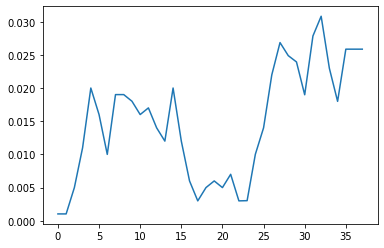

In [86]:
plt.plot(c.optimizer._opt_trials_losses)